In [13]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import plotly.express as px

In [2]:
CRS_GEODETIC = "EPSG:4326"
CRS_GEODESIC = "EPSG:23839"

PLACE_NORM = {
    # from houses to SHP
    # "Pajajaran": "Babakan",
    # "Taman Kencana": "Babakan",
    "Babakan Madang": "Babakanmadang",
    # "Bukit Sentul": "Babakanmadang",
    "Babakan Pasar": "Babakanpasar",
    "Balumbang Jaya": "Balumbangjaya",
    "Bantar Jati": "Bantarjati",
    # "Indraprasta": "Bantarjati",
    # "Ardio": "Bogor Tengah",
    "Bojong Gede": "Bojonggede",
    "Bojong Kulur": "Bojongkulur",
    # "Cilendek": "Cilendek Barat",
    "Curug Mekar": "Curugmekar",
    "Gunung Batu": "Gunungbatu",
    "Gunung Putri": "Gunungputri",
    # "Kota Wisata": "Gunungputri",
    # "Legenda Wisata": "Gunungputri",
    # "Kranggan": "Gunungputri",
    "Gunung Sindur": "Gunungsindur",
    # "Harjamukti": "INI GA ADA DI SHP",
    "Karang Tengah": "Karangtengah",
    "Kebon Kelapa": "Kebonkalapa",
    "Kedungbadak": "Kedungbadak",
    "Kedung Halang": "Kedunghalang",
    "Leuwinanggung": "Lewinanggung",
    # "Jl Dr Semeru": "Menteng",
    "Muara Sari": "Muarasari",
    # "Bogor Nirwana Residence": "Mulyaharja",
    "Parung Panjang": "Parungpanjang",
    "Pasir Jaya": "Pasirjaya",
    "Pasir Kuda": "Pasirkuda",
    "Pasir Muncang": "Pasirmuncang",
    "Ranca Bungur": "Rancabungur",
    "Rangga Mekar": "Ranggamekar",
    "Sentul City": "Sentul",
    "Sindang Barang": "Sindangbarang",
    "Sindang Sari": "Sindangsari",
    "Situ Gede": "Situgede",
    "Tajur Halang": "Tajurhalang",
    # "Ahmadyani": "Tanahsareal",
    # "Jl A Yani": "Tanahsareal",
    "Tanah Sareal": "Tanahsareal",
    "Tegal Gundi": "Tegalgundil",
    "Tegal Gundil": "Tegalgundil",
    "Duta Pakuan": "Tegallega",

    # dedupe in SHP
    "Bantar Gebang" :"Bantargebang",
}

## Load Spatial Data

In [3]:
df_bogor = pd.concat([
  gpd.read_file("../dataset/shp/kota/ADMINISTRASIDESA_AR_25K.shp"), 
  gpd.read_file("../dataset/shp/kab/ADMINISTRASIDESA_AR_25K.shp")
])

df_bogor = df_bogor[["NAMOBJ", "WADMKC", "WADMKK", "WADMPR", "SHAPE_Leng", "SHAPE_Area", "geometry"]]
df_bogor.head()

,NAMOBJ,WADMKC,WADMKK,WADMPR,SHAPE_Leng,SHAPE_Area,geometry
0,Atangsenjaya,Kemang,Bogor,Jawa Barat,0.050011,0.000142,"MULTIPOLYGON Z (((106.76135 -6.54978 0.00000, ..."
1,Babakan,Bogor Tengah,Kota Bogor,Jawa Barat,0.039368,0.000084,"POLYGON Z ((106.81147 -6.58549 0.00000, 106.81..."
2,Babakan,Dramaga,Bogor,Jawa Barat,0.090427,0.000272,"MULTIPOLYGON Z (((106.73532 -6.56320 0.00000, ..."
3,Babakanpasar,Bogor Tengah,Kota Bogor,Jawa Barat,0.022805,0.000026,"POLYGON Z ((106.80666 -6.60793 0.00000, 106.80..."
4,Balumbangjaya,Bogor Barat,Kota Bogor,Jawa Barat,0.056478,0.000109,"POLYGON Z ((106.74774 -6.56118 0.00000, 106.74..."


In [4]:
df_bogor.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

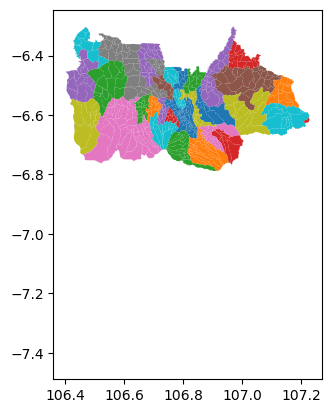

In [5]:
df_bogor.plot(column="WADMKC")

### Load OSM Amenities

In [6]:
# https://epsg.io/4326
# WGS 84 -- WGS84 - World Geodetic System 1984, used in GPS

df_overpass_raw = pd.read_csv("../dataset/curated/marts_spatial_amenities.csv")
df_overpass = gpd.GeoDataFrame(df_overpass_raw, geometry=gpd.points_from_xy(df_overpass_raw.lon, df_overpass_raw.lat), crs=CRS_GEODETIC)
df_overpass = df_overpass.drop(columns=["lat", "lon"])

df_overpass.head()

,id,rel,amenity,object_type,category,geometry
0,1556616316,14745927,atm,node,financial,POINT (106.78389 -6.59477)
1,1559543608,14745927,atm,node,financial,POINT (106.77924 -6.59930)
2,1562243374,14745927,atm,node,financial,POINT (106.79275 -6.59560)
3,1572737771,14745927,atm,node,financial,POINT (106.77927 -6.59930)
4,1736011930,14745927,atm,node,financial,POINT (106.80967 -6.60704)


### Load House Prices

In [7]:
df_houses = pd.read_parquet("../dataset/curated/marts_llm_houses.parquet", columns=["city", "district", "price"])
df_houses.head()

,city,district,price
0,Bogor,Sentul City,1400.0
1,Bogor,Gunung Putri,700.0
2,Bogor,Gunung Putri,2700.0
3,Bogor,Bogor Barat,1370.0
4,Bogor,Bogor Selatan,1800.0


## Join Datasets

### Join Spatial Data with OSM Ameninties

In [8]:
# https://epsg.io/23839
# DGN95 / Indonesia TM-3 zone 51.1

df_places = gpd.sjoin_nearest(df_bogor.to_crs(CRS_GEODESIC), df_overpass.to_crs(CRS_GEODESIC), distance_col="distance").drop(columns=["index_right"])
df_places = pd.DataFrame(df_places.drop(columns=["geometry", "SHAPE_Leng", "SHAPE_Area"]))

df_places.head()

,NAMOBJ,WADMKC,WADMKK,WADMPR,id,rel,amenity,object_type,category,distance
0,Atangsenjaya,Kemang,Bogor,Jawa Barat,8961582717,14745927,school,node,education,143.420189
1,Babakan,Bogor Tengah,Kota Bogor,Jawa Barat,183499017,14745927,parking,way,transportation,0.000000
1,Babakan,Bogor Tengah,Kota Bogor,Jawa Barat,5507176222,14745927,cafe,node,sustenance,0.000000
1,Babakan,Bogor Tengah,Kota Bogor,Jawa Barat,7074116281,14745927,restaurant,node,sustenance,0.000000
1,Babakan,Bogor Tengah,Kota Bogor,Jawa Barat,5614646423,14745927,school,node,education,0.000000


### Normalize District Names

In [9]:
# df_houses["place"] = df_houses["district"]
df_houses["place"] = df_houses["district"].replace(PLACE_NORM)

avg_house_prices = df_houses.groupby("place")["price"].mean()
avg_house_prices.head()

place
Ahmadyani         6619.333333
Ardio              643.333333
Babakan           9951.500000
Babakanmadang     5329.312000
Babakanpasar     10200.000000
Name: price, dtype: float64

In [10]:
# join dataset
df_amenities = pd.concat([
    # df_places.pivot_table(index="WADMKC", columns="category", values="id", aggfunc="count", fill_value=0).reset_index().rename(columns={"WADMKC": "place"}),
    df_places.pivot_table(index="NAMOBJ", columns="category", values="id", aggfunc="count", fill_value=0).reset_index().rename(columns={"NAMOBJ": "place"}),
])

df_amenities["place"] = df_amenities["place"].replace(PLACE_NORM)
df_amenities.head()

category,place,education,entertainment,facilities,financial,healthcare,public_service,sustenance,transportation
0,Ambar Jaya,1,0,0,0,0,0,0,0
1,Antajaya,0,0,0,0,0,0,1,0
2,Argapura,0,0,0,0,0,0,1,0
3,Atangsenjaya,1,0,0,0,1,0,0,0
4,Babakan,21,0,1,18,4,1,21,17


In [11]:
df_summary = df_amenities.join(avg_house_prices, on="place", how="right").reset_index(drop=True)
df_summary.sort_values("price", ascending=False).head().style.background_gradient(cmap="Blues")

,place,education,entertainment,facilities,financial,healthcare,public_service,sustenance,transportation,price
45,Cimande,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,30750.000000
33,Cijayanti,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,24558.166667
30,Cibuluh,2.000000,0.000000,0.000000,3.000000,0.000000,2.000000,1.000000,3.000000,12313.000000
81,Klapanunggal,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,10938.214286
68,Harjasari,8.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3.000000,10533.333333


<Axes: >

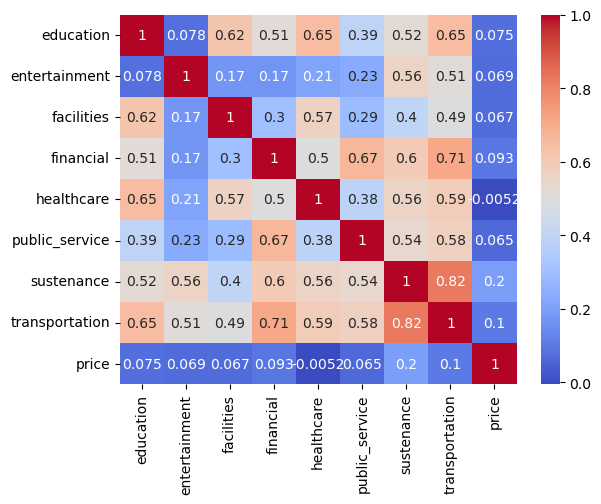

In [12]:
sns.heatmap(df_summary.corr(numeric_only=True), annot=True, cmap="coolwarm")

In [20]:
# summary of listings per district
df_choro = df_houses.groupby("district") \
    .agg({"price": "median", "district": "size"}) \
    .rename(columns={"district": "count"}) \
    .reset_index() 

df_choro.head()

,district,price,count
0,Ahmadyani,4000.0,15
1,Ardio,530.0,3
2,Babakan,7795.0,50
3,Babakan Madang,2000.0,125
4,Babakan Pasar,5000.0,5


<Axes: xlabel='district'>

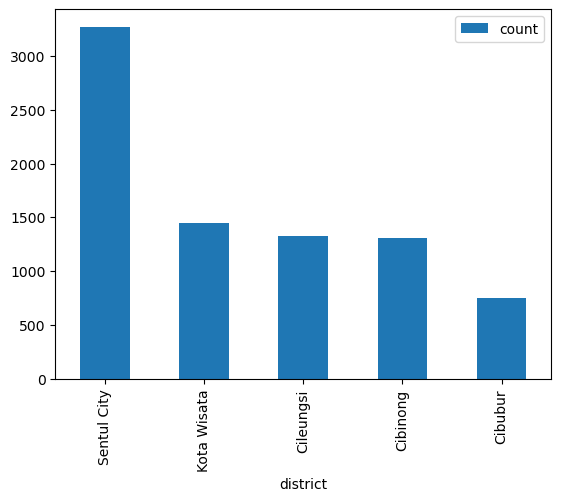

In [27]:
df_choro.sort_values("count", ascending=False).head().drop(columns=["price"]).set_index("district").plot.bar()

In [ ]:
# plot choropleth map
ch_choro = px.choropleth_mapbox(df_choro,
                                geojson=df_bogor,
                                locations="district",
                                featureidkey="properties.NAMOBJ",
                                color="count",
                                color_continuous_scale="Viridis",
                                mapbox_style="carto-positron",
                                zoom=10,
                                center={
                                    "lat": -6.6,
                                    "lon": 106.8
                                },
                                opacity=0.5,
                                hover_data={
                                    "district": True,
                                    "count": True,
                                    "price": ":,.0f"
                                })
ch_choro.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
# ch_choro.update_layout(coloraxis_showscale=False)
ch_choro.show()